## Coding attention mechanism
In this chapter **Sebastian** proposes four different implementation of the attention mechanism. The main goal is to aarrive at a compact and efficent implementation of multi-head attention.

**[1]** *Simplified self-attention* - **[2]** *Self-attention* - **[3]** *Causal attention* - **[4]** *Multi-head attention*

Let introduce the concepts of encoder and decoder. Deep neural network are composed by these two different sub-module (already used during RNN period).
In general, encoder's goal is to process the entire input text into a hidden state, which gives a general overview of the internal state of the model and
next the decoder takes in this hidden state to produce the output.

Inspired by Bahdanau attention mechanism, researcher released *transformer architecture* only three years later than RNN.

**Self-attention mechanism** is a mechanism that allows each position in the input sequence to consider the relevancy of, or "attend to", all other positions in the same sequence when computing the representation of a sequence. Self-attention is a key component of contemporary LLMs based on the transformer architecture, such as the GPT series.



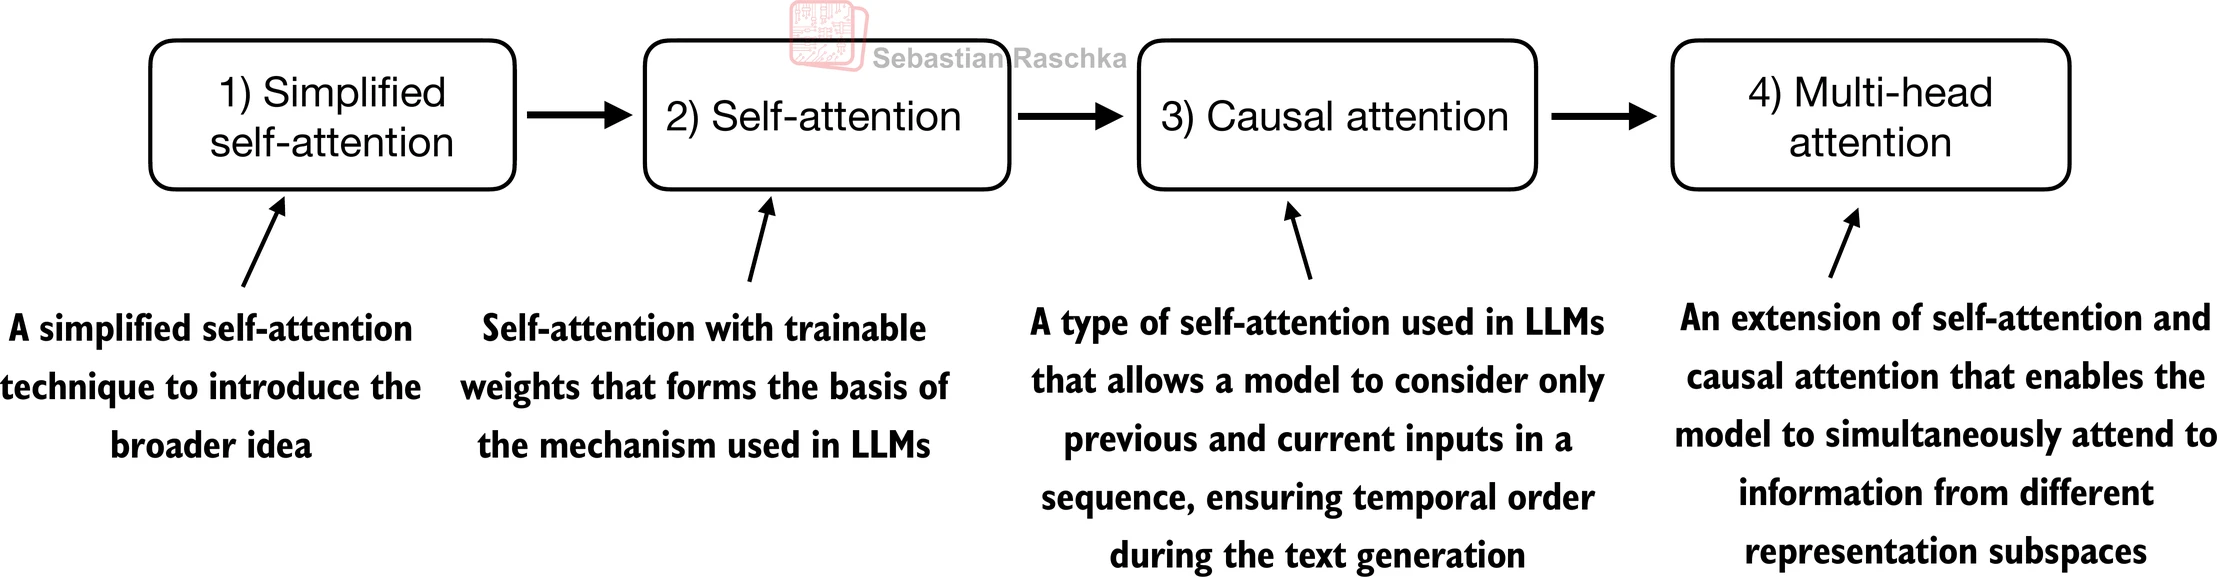

##### Explanation
In self-attention, the "self" refers to the mechanism's ability to compute attention weights by relating different positions within a single input sequence.It assesses and learns the relationships and dependencies between various parts of the input itself, such as words in a sentence or pixels in a image.

The expected output are context vectors for each input element that combines information from all other input elements weighted with respect to input element.

**Context vectors** play a crucial role in self-attention. Their purpose is to create **enriched** representation of each element in an input sequence by incorporating infromation from all other elements in the sequences.

In [ ]:
from importlib.metadata import version
print("torch version:", version("torch"))

#### Simplified self-attention

In [ ]:
import torch

# rows = samples
# columns = features

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [ ]:
query = inputs[1]  # 2nd input token is the query

# computing attention weight a_2i with i from 0 to T.
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

"""
Dot-product come from the multiplication of two vectors elements-wise and summing the resulting products.

    SCRATCH IMPLEMENTATION
    for idx, element in enumerate(inputs[0]):
        res += inputs[0][idx] * query[idx]

NOTE: This operation is a mathematical tool used to measure the similarity because it quantifies how closely two vectors are aligned. 
"""

print(attn_scores_2)

In [ ]:
# To ensuring stability during training phases, normalization is required.

# Raw method
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

# Softmax method (numerical issues can happaned creating instability)
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

# NOTE: softmax ensures positive numbers, making easier to interpretate the attention weights as probabilities or relative importance.

# Softmax optimized
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

In [ ]:
# Now we can compute the context vector z^2 
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

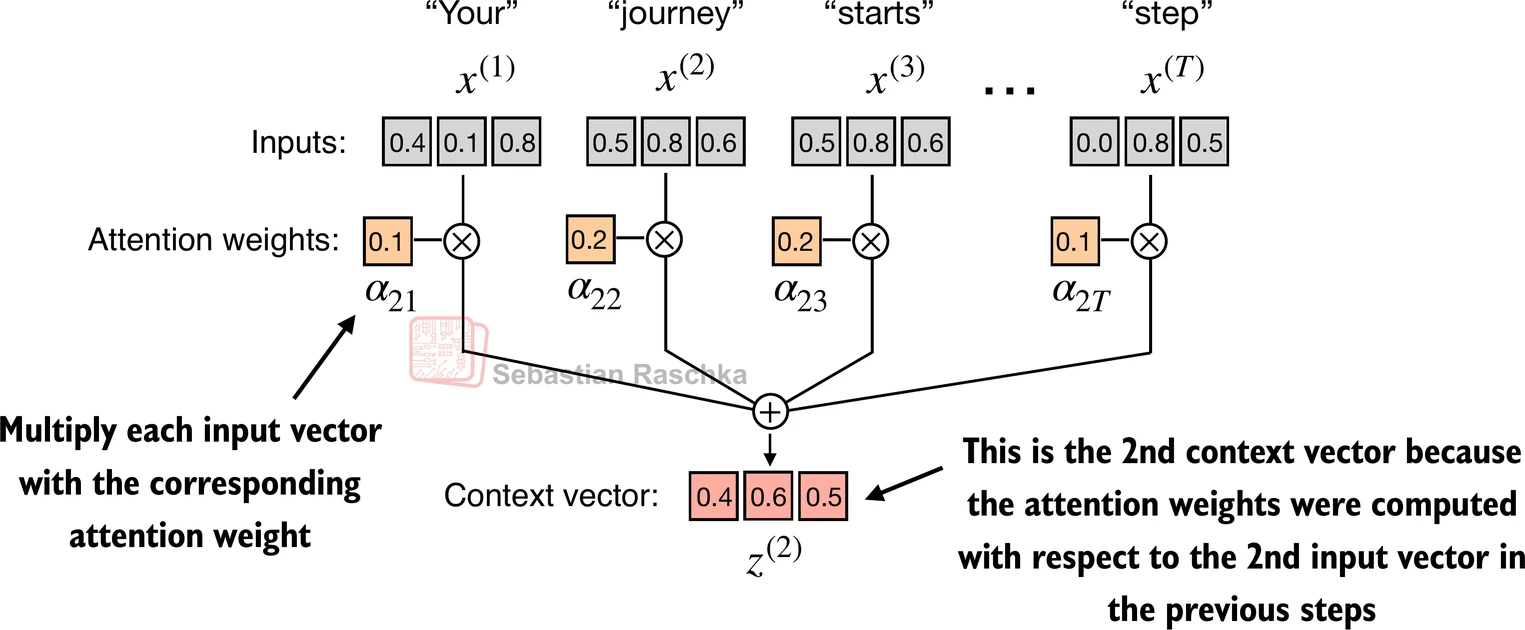

##### Computing attention weights for all input tokens

Now we will generalize the computation to obtain all other attention weights.

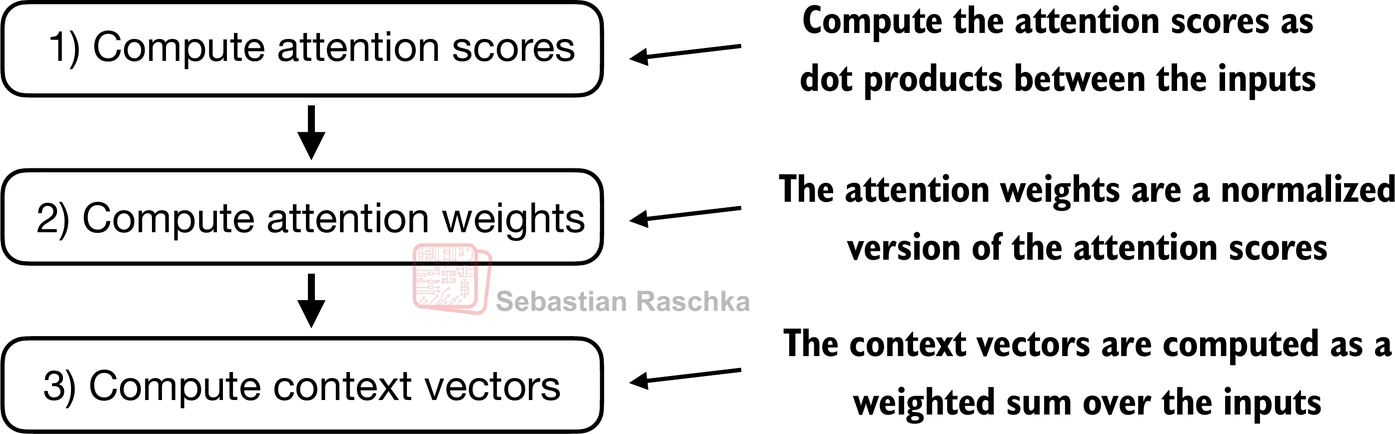

In [ ]:
# 1. Pairwise elements to compute unnormalized attention score matrix
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(f"Attention score 1 : {attn_scores}")

# More efficient way using matrix moltiplication

attn_scores = inputs @ inputs.T
print(f"Attention score 2 : {attn_scores}")

# 2. Normalize each row
attn_weights = torch.softmax(attn_scores, dim=-1)  # dim = -1 to normalize along the last dimension
print(f"Attention weight: {attn_weights}")

# 3. Compute all context vectors

all_context_vecs = attn_weights @ inputs
print(all_context_vecs)
print(f"Context vectors: {all_context_vecs}")

#### Self-attention with trainable weights

Implementing the scaled dot-product attention. The differents respect the previous implementation is the introduction of weight matrices that are updated during the training phase.

The terms "key", "query" and "value" are borrowed from the domain of database. 
- Query is used to probe the other parts of the input sequence to determine how much attention to pay to them.
- Key is used for indexing and searching. These key are used to match query.
- Value rapresents the actual content or representation of the input items. 

Model determines which keys are most relevant to the query, it retrives the corrisponding values.

In [ ]:
# Step by step

# 1. Introducing the three trainable weight matrices W_q, W_k, and W_v. 
'''
This matrices are used to project the embedded input tokens, x^(i), into query, key, and value vectors.
    - Query vector:   q^(i) = x^(i) * W_q
    - Key vector:     k^(i) = x^(i) * W_k
    - Value vector:   v^(i) = x^(i) * W_v
'''
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

# 2. Init three matrices

torch.manual_seed(123)

# ATTENTION: requires_grad is set to False reducing clutter in the output. If we were to use the weight matrices for model training, we would set requires_grad=True to update these matrices during model training
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

# 3. Compute Q, K, V
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print(query_2)

# 4. Generalizing
keys = inputs @ W_key 
values = inputs @ W_value

print("We successfully projected the six input tokens from a three-dimension space onto a two-dimension embedding space.\n")
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

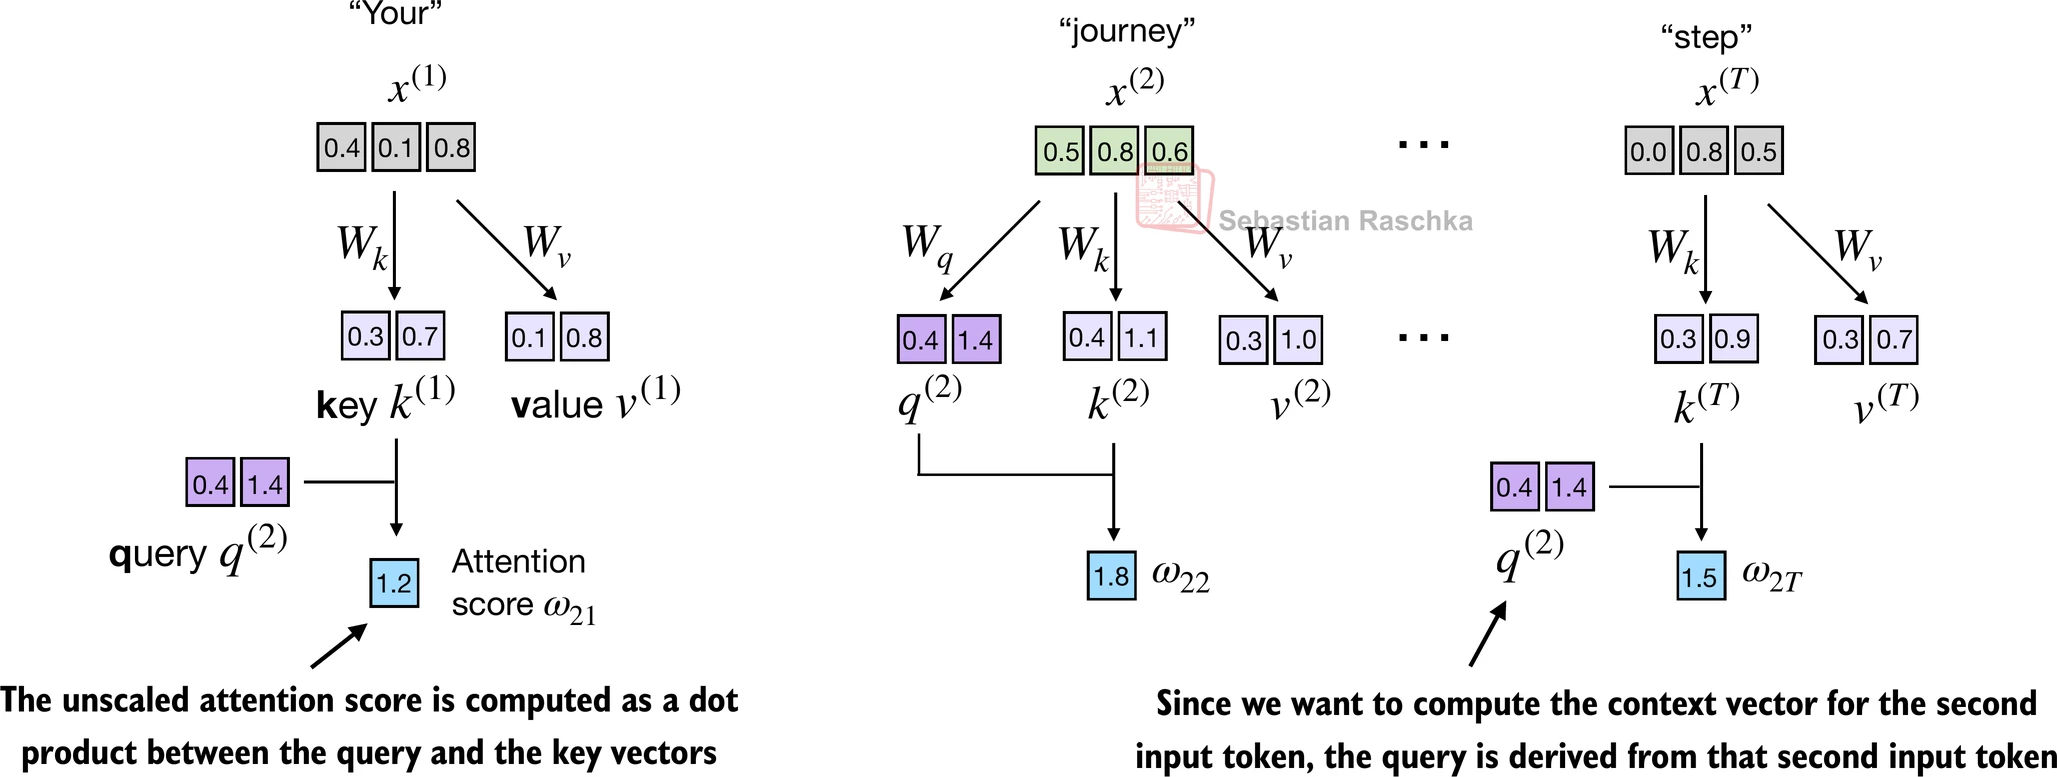

In [ ]:
# Computing the attention score Omega_22

keys_2 = keys[1] # Python starts index at 0
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

In [ ]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query (used to compute context vector 2)
print(attn_scores_2)

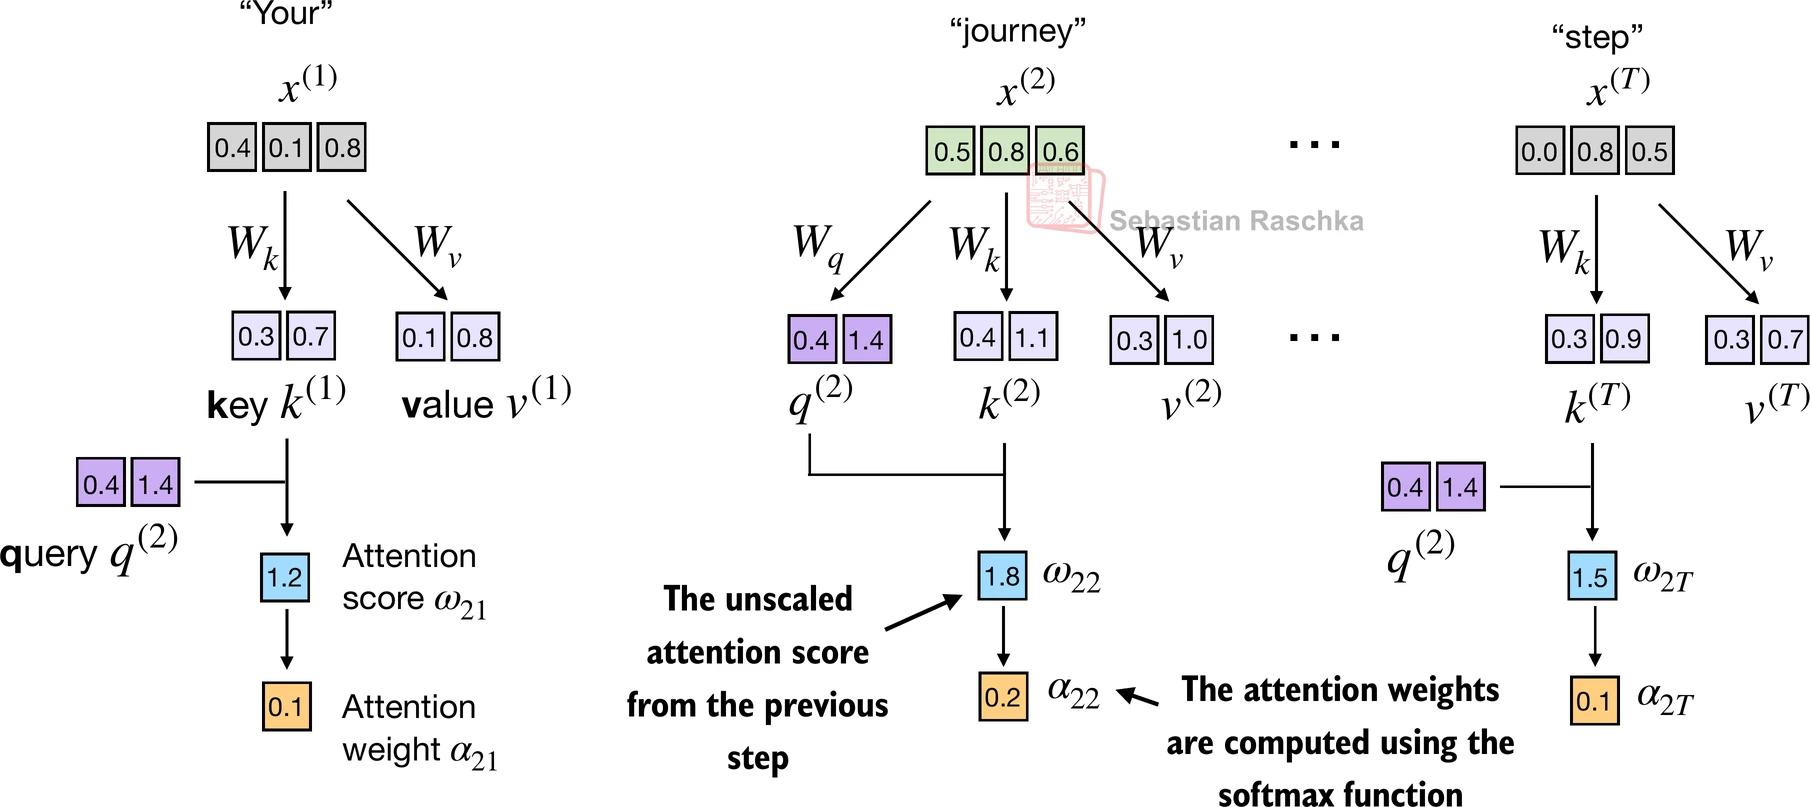

In [ ]:
d_k = keys.shape[1]
# Computing the attention weight scaling the attention score and dividing them by the square root of the embedding dimension (done to avoid vanish gradient issues coming from small gradients. These can drastically slow down learning or cause training to stagnate). 
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

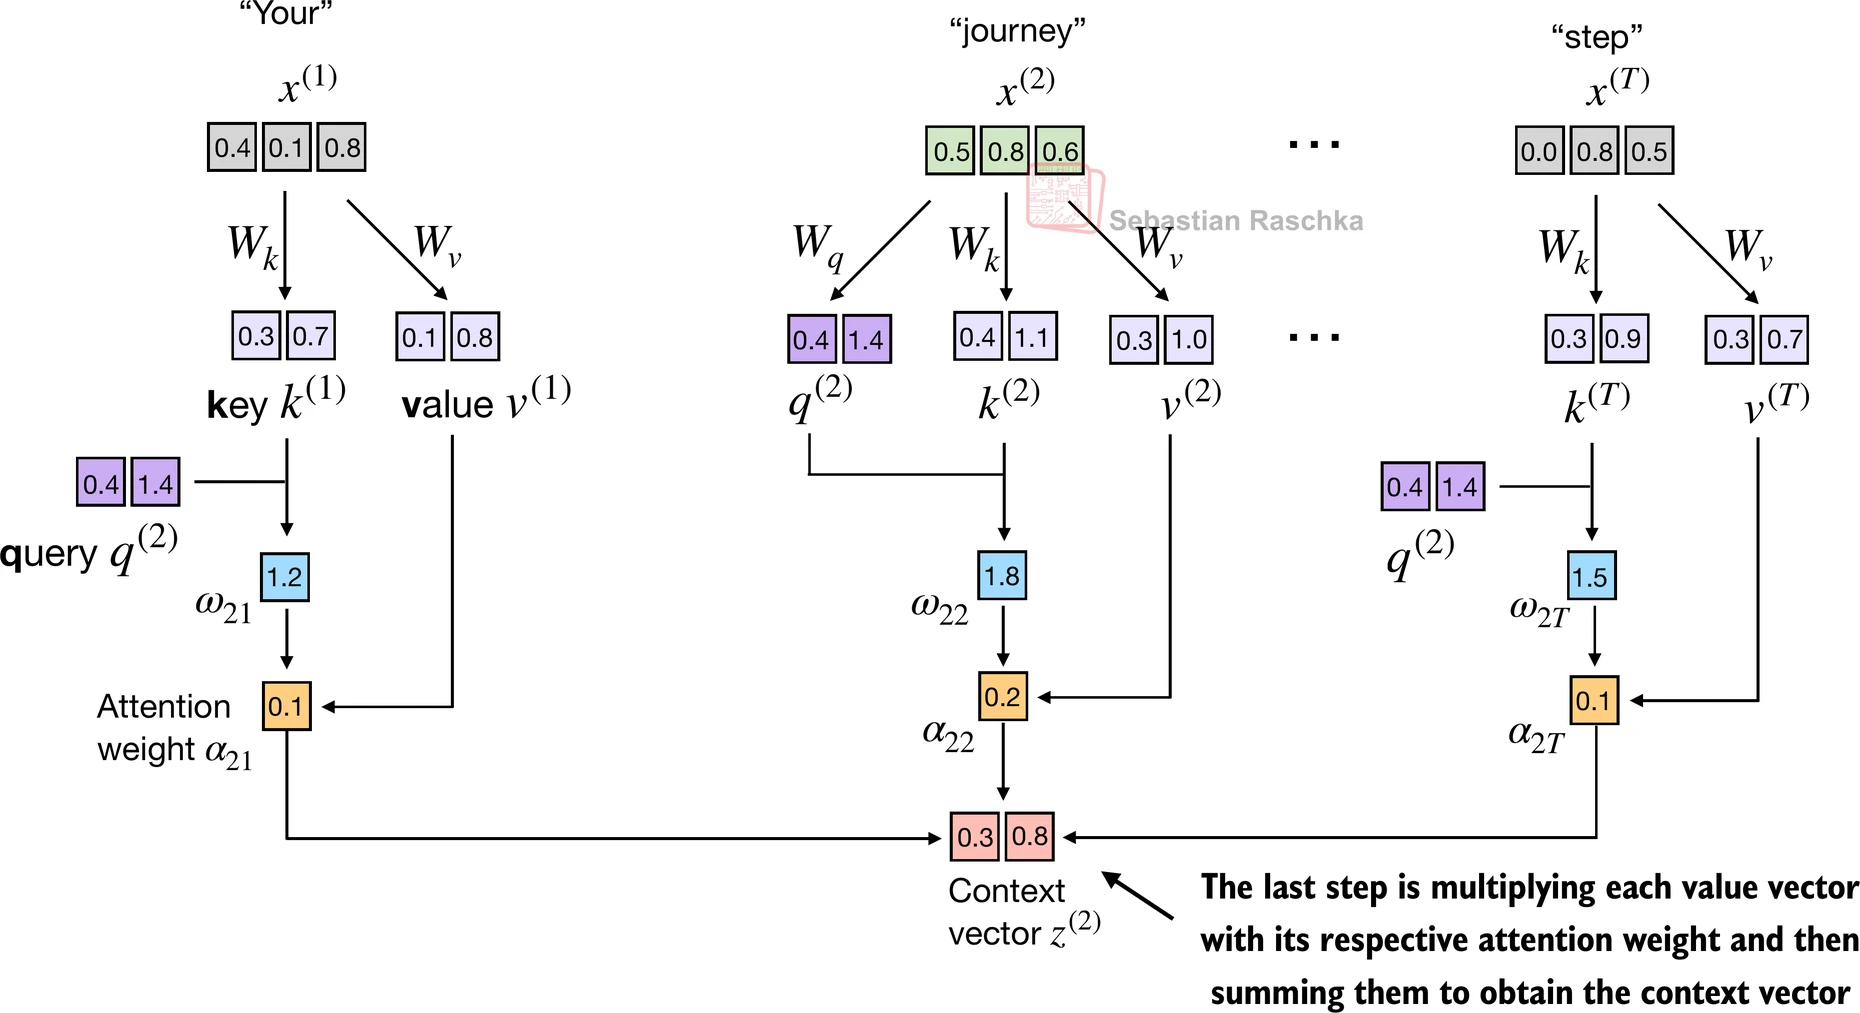

In [ ]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

#### Self-Attention Class implementation

In [ ]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out, *args, **kwargs):
        super().__init__(*args, **kwargs) 
        # init trainable weight matrices W_q, W_k, and W_v using torch.
        self.W_query = nn.Parameter(torch.randn(d_in, d_out))
        self.W_key = nn.Parameter(torch.randn(d_in, d_out))
        self.W_value = nn.Parameter(torch.randn(d_in, d_out))

    def forward(self, x):
        # given an input x, we can compute q_q, q_k and q_v vectors.
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        # computing the similarity
        attn_scores = queries @ keys.T # omega

        # computing the attention weights, normalizing and apllying softmax 
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim = -1)

        # Now we can compute the context vector by weighting the values with these normalized attention scores.
        context_vec = attn_weights @ values
        
        return context_vec